# Title- Bike Sharing

### Competition Description

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

#### Practice Skills
###### Regression
---
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Data Fields
datetime - hourly date + timestamp

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 

2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 

3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 

4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

### Overview

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

training set (train.csv)
test set (test.csv)

---
### 1.Prepare Problem
#### a.Load libraries
#### b.Load dataset
##### for this problem we will be loading training set and test  from two files as given by kaggle 

In [1]:
import os
import math
import datetime
import calendar
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.mlcommon import load_data, print_dataset_info, load_dataset ,detect_outliers,display_data_descriptives

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
 
% matplotlib inline 
from numpy import set_printoptions
set_printoptions(precision=4)
sns.set(style="white", color_codes=True)

In [2]:
load_app_config()
DIRECTORY="bike_sharing"
TRAIN_FILE ='train.csv'
TEST_FILE = 'test.csv'
RESPONSE = 'count'
input_path = get_datafolder_path()

Adding F:\DataSource  to system path
Adding F:\MachineLearning  to system path


In [3]:
train_file = os.path.join(input_path, DIRECTORY, TRAIN_FILE)
test_file = os.path.join(input_path, DIRECTORY, TEST_FILE)

train_dataset,feature_columns,response_column,continuous_vars,categorical_vars = load_dataset(train_file,RESPONSE,colseparator=',')
test_dataset,tfeature_columns,tresponse_column,tcontinuous_vars,tcategorical_vars = load_dataset(test_file,RESPONSE,colseparator=',')    
    

 input file is :F:\DataSource\bike_sharing\train.csv loaded.
Continous Variables
['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
Categorical Variables
['datetime']
 input file is :F:\DataSource\bike_sharing\test.csv loaded.
Continous Variables
['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
Categorical Variables
['datetime']


In [4]:
### pandas 
### The day of the week with Monday=0, Sunday=6
def create_features(dataset):
    dataset["datetime_tmp"] = pd.to_datetime(dataset["datetime"])
    dataset['year'] = dataset['datetime_tmp'].dt.year
    dataset['month'] = dataset['datetime_tmp'].dt.month
    dataset['day'] = dataset['datetime_tmp'].dt.day
    dataset['hour'] = dataset['datetime_tmp'].dt.hour
    dataset['minute'] = dataset['datetime_tmp'].dt.minute
    dataset["weekday"] = dataset["datetime_tmp"].apply(lambda date : date.weekday())
    dataset["dayname"] = dataset["datetime_tmp"].apply(lambda date : calendar.day_name[date.weekday()])
    dataset["monthname"] = dataset["datetime_tmp"].apply(lambda date : calendar.month_name[date.month])
    return dataset

train_dataset  = create_features(train_dataset)
test_dataset = create_features(test_dataset)

### Outliers Analysis

In [5]:
outliers_to_drop = detect_outliers(train_dataset,2,["count"])
print(train_dataset.loc[outliers_to_drop])
print("Before dropping outliers  :{0}" .format(train_dataset.shape))
train_dataset = train_dataset.drop(outliers_to_drop, axis = 0).reset_index(drop=True)
print("After dropping outliers  :{0}" .format(train_dataset.shape))

Empty DataFrame
Columns: [datetime, season, holiday, workingday, weather, temp, atemp, humidity, windspeed, casual, registered, count, datetime_tmp, year, month, day, hour, minute, weekday, dayname, monthname]
Index: []

[0 rows x 21 columns]
Before dropping outliers  :(10886, 21)
After dropping outliers  :(10886, 21)


---
### 2.Summarize Data 
#### a) Descriptive statistics
#### b) Data visualizations

In [6]:
sort_order  = train_dataset['month'].unique()
sort_order =list(sort_order)
week_order =train_dataset['weekday'].unique()
week_order =list(week_order)

In [7]:
pd.set_option('display.width', 120)
pd.set_option('precision', 4)
display_data_descriptives(train_dataset,feature_columns,response_column)
#display_data_descriptives(test_dataset,tfeature_columns,tresponse_column,tcontinuous_vars,tcategorical_vars)
print(test_dataset.info())
print("<{0} {1} {0}>".format("="*40,"train data header"))


<======================================== info ========================================>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 21 columns):
datetime        10886 non-null object
season          10886 non-null int64
holiday         10886 non-null int64
workingday      10886 non-null int64
weather         10886 non-null int64
temp            10886 non-null float64
atemp           10886 non-null float64
humidity        10886 non-null int64
windspeed       10886 non-null float64
casual          10886 non-null int64
registered      10886 non-null int64
count           10886 non-null int64
datetime_tmp    10886 non-null datetime64[ns]
year            10886 non-null int64
month           10886 non-null int64
day             10886 non-null int64
hour            10886 non-null int64
minute          10886 non-null int64
weekday         10886 non-null int64
dayname         10886 non-null object
monthname       10886 non-null object
dtypes:

In [8]:
train_dataset.head() 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,datetime_tmp,year,month,day,hour,minute,weekday,dayname,monthname
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,16,2011-01-01 00:00:00,2011,1,1,0,0,5,Saturday,January
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,40,2011-01-01 01:00:00,2011,1,1,1,0,5,Saturday,January
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,32,2011-01-01 02:00:00,2011,1,1,2,0,5,Saturday,January
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,13,2011-01-01 03:00:00,2011,1,1,3,0,5,Saturday,January
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,1,2011-01-01 04:00:00,2011,1,1,4,0,5,Saturday,January


### Inferences from descriptive statistics
#### Minimum values of humidity  and windspeed  is zero . Can this be possible ?

In [9]:
### check the counts  for zero  humidity and windspeed 
train_dataset[train_dataset['humidity']==0]['count'].count()

22

In [10]:
train_dataset[train_dataset['windspeed']==0]['count'].count()

1313

### Univariate plots 

In [11]:
train_dataset = train_dataset[train_dataset['humidity']>0]

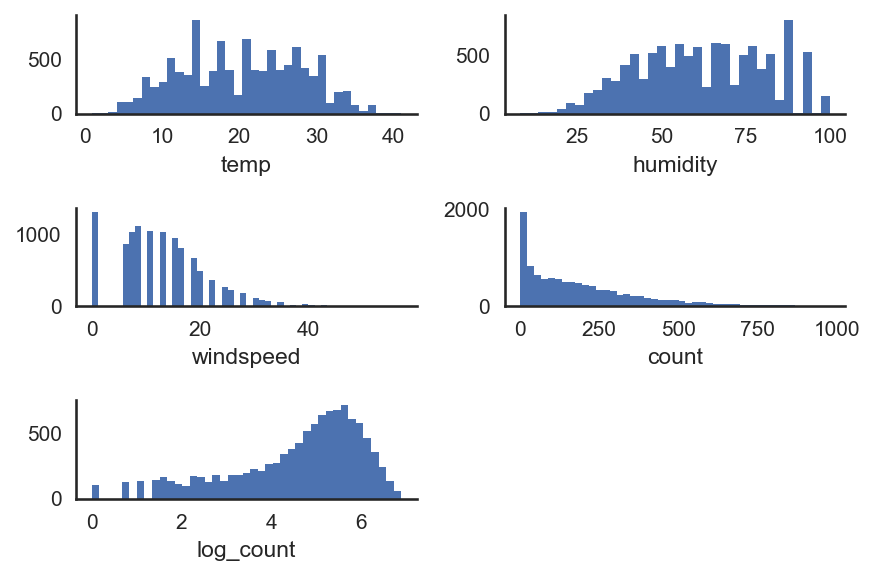

In [12]:
train_dataset['log_count'] =  np.log(train_dataset['count'])
continuous_features =['temp', 'humidity', 'windspeed','count','log_count']
def dist_plots(train_dataset,continuous_features):
    fig = plt.figure(figsize=(6,4),dpi=150)
    size =len(continuous_features)
     
    for i in range(size):
        ax = fig.add_subplot(3, 2, i+1)
        sns.distplot(train_dataset[train_dataset[continuous_features[i]].notnull()][continuous_features[i]],ax=ax ,
                     kde =False,hist_kws=dict(alpha=1))
        sns.despine()
    plt.tight_layout()
    plt.show()
dist_plots(train_dataset,continuous_features)

In [15]:
from scipy.stats  import boxcox
bc_temp, temp_lambda = boxcox(train_dataset['temp'])
print('Optimal lambda value for temperature:', temp_lambda)
bc_humidity,humidity_lambda = boxcox(train_dataset['humidity'])
print('Optimal lambda value for humidity:', humidity_lambda)

Optimal lambda value for temperature: 0.837383023937
Optimal lambda value for humidity: 0.911872232744


In [19]:
train_dataset['bc_temp']=bc_temp
train_dataset['bc_humidity']=bc_humidity

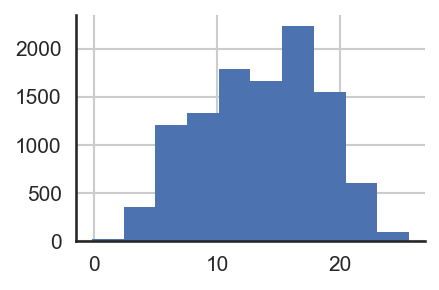

In [20]:
fig = plt.figure(figsize=(3,2),dpi =150)
ax =fig.gca()
train_dataset['bc_temp'].hist(ax=ax,grid =None)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

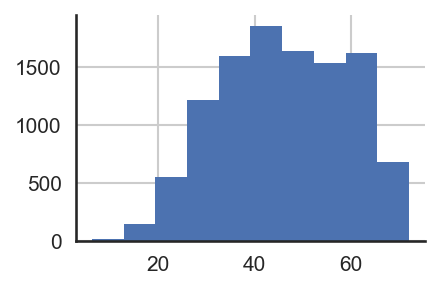

In [21]:
fig = plt.figure(figsize=(3,2),dpi =150)
ax =fig.gca()
train_dataset['bc_humidity'].hist(ax=ax,grid =None)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [22]:
train_dataset.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,hour,minute,weekday,dayname,monthname,log_count,temp_scaled,humidity_scaled,bc_temp,bc_humidity
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,0,0,5,Saturday,January,2.7726,-1.3339,0.9962,6.9078,59.2094
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,1,0,5,Saturday,January,3.6889,-1.4391,0.9437,6.3385,58.5301
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,2,0,5,Saturday,January,3.4657,-1.4391,0.9437,6.3385,58.5301
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,3,0,5,Saturday,January,2.5649,-1.3339,0.6814,6.9078,55.1223
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,4,0,5,Saturday,January,0.0000,-1.3339,0.6814,6.9078,55.1223


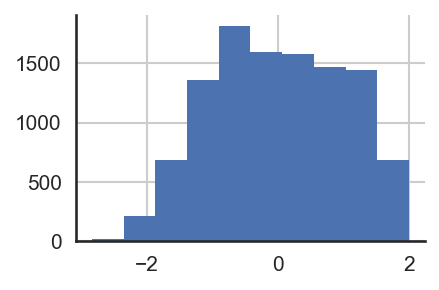

In [14]:
fig = plt.figure(figsize=(3,2),dpi =150)
ax =fig.gca()
train_dataset['humidity_scaled'].hist(ax=ax,grid=None)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
std_scaler = StandardScaler()
train_dataset["temp_scaled"] =std_scaler.fit_transform(train_dataset["temp"].values.reshape(-1, 1))
test_dataset["temp_scaled"]=std_scaler.transform(test_dataset["temp"].values.reshape(-1, 1))
train_dataset["humidity_scaled"] =std_scaler.fit_transform(train_dataset["humidity"].values.reshape(-1, 1))
test_dataset["humidity_scaled"]=std_scaler.transform(test_dataset["humidity"].values.reshape(-1, 1))

F:\Anaconda2\envs\machinelearning\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
